In [1]:
# Preprocessing - Day 6 Zebrafish scRNA-seq
#This notebook performs preprocessing, quality control, normalization, and scaling for Day 6 zebrafish caudal fin regeneration single-cell RNA-seq data.
#Series GSE261907-GEO omnibus

In [2]:
# =============================================
# Import Libraries & Set Up Environment
# =============================================
import scanpy as sc          # Single-cell analysis toolkit
import matplotlib.pyplot as plt  # Plotting
import seaborn as sns        # Enhanced visualizations
import pandas as pd          # Data manipulation
import numpy as np           # Numerical operations

# =============================================
# Configure Visualization Settings
# =============================================
# Scanpy settings for figures (high-quality saves)
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=300)

# Seaborn style for clean, grid-based plots
sns.set(style="whitegrid")

In [3]:
# =============================================
# Load 10x Genomics scRNA-seq Data
# =============================================
adata = sc.read_10x_mtx(
    "E:/Informatics project/Zebrafish fin regeneration/data/6 DPA 1st",  # Directory containing matrix.mtx, genes.tsv, and barcodes.tsv
    var_names='gene_symbols',  # Use gene symbols (instead of Ensembl IDs) as variable names
    cache=True                # Cache the data for faster reloading
)

# Ensure unique gene names (avoids duplicates like 'GeneA-1', 'GeneA-2')
adata.var_names_make_unique()

# Display the AnnData object (shows cell x gene matrix dimensions and metadata)
adata

AnnData object with n_obs × n_vars = 12371 × 27407
    var: 'gene_ids', 'feature_types'

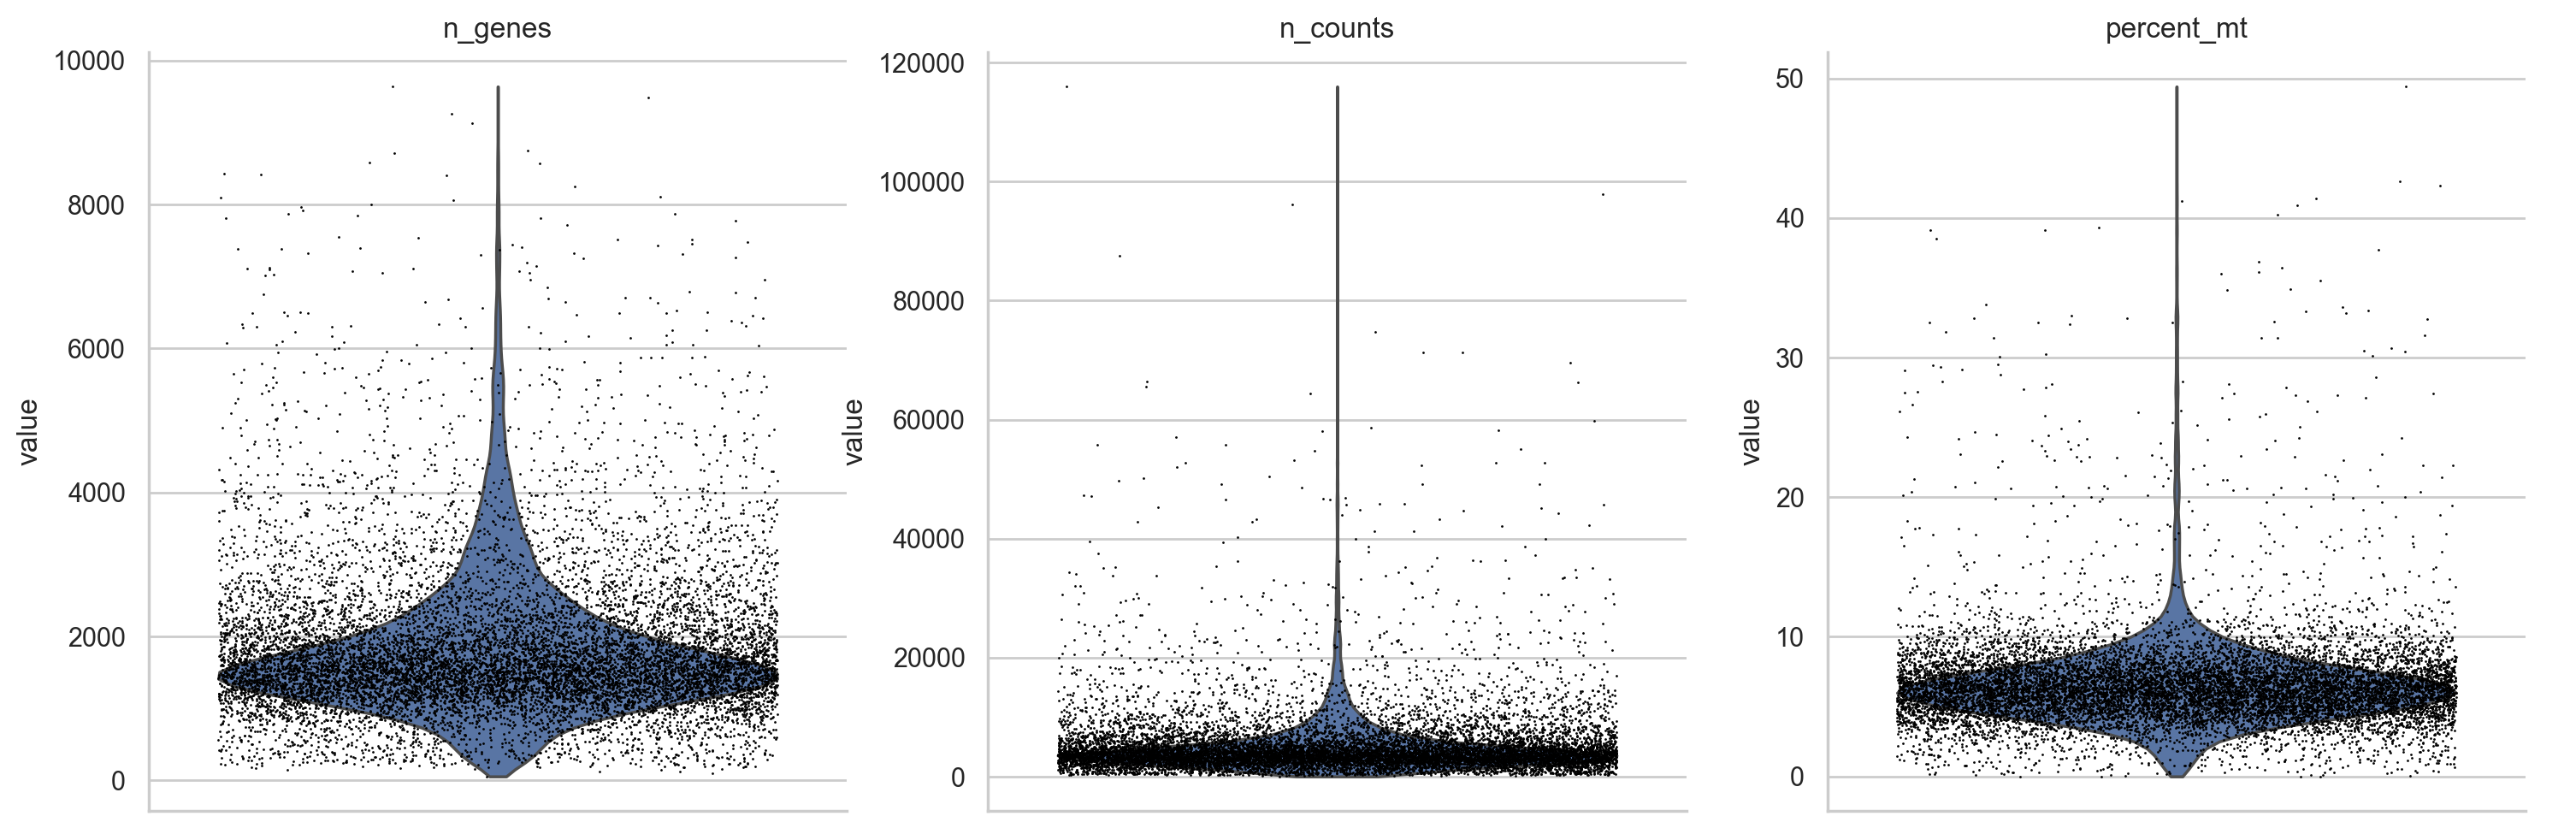


🔍 QC Summary Statistics:

            n_genes       n_counts    percent_mt
count  12371.000000   12371.000000  12371.000000
mean    1840.155768    5217.492676      6.572586
std     1040.930853    5659.309082      3.343163
min       57.000000      65.000000      0.000000
25%     1246.000000    2716.000000      4.899755
50%     1594.000000    3807.000000      6.182366
75%     2138.000000    5628.000000      7.533108
max     9638.000000  115964.000000     49.418083


In [4]:
# =============================================
# Calculate Basic QC Metrics
# =============================================
# Total counts (UMIs) per cell
adata.obs['n_counts'] = adata.X.sum(axis=1).A1  

# Number of genes detected per cell (non-zero counts)
adata.obs['n_genes'] = (adata.X > 0).sum(axis=1).A1  

# =============================================
# Mitochondrial Gene Percentage (Optional but Recommended)
# =============================================
# Identify mitochondrial genes (prefix 'mt-' in gene symbols)
adata.var['mt'] = adata.var_names.str.startswith('mt-')  

# Calculate % mitochondrial reads per cell
adata.obs['percent_mt'] = (
    np.sum(adata[:, adata.var['mt']].X, axis=1).A1 / adata.obs['n_counts'] * 100
)

# =============================================
# Visualize QC Metrics
# =============================================
# Violin plots for n_genes, n_counts, and percent_mt
sc.pl.violin(
    adata, 
    ['n_genes', 'n_counts', 'percent_mt'], 
    jitter=0.4,  # Add jitter for better visibility of data points
    multi_panel=True  # Split into subplots
)

# =============================================
# Display QC Summary Statistics
# =============================================
qc_summary = adata.obs[['n_genes', 'n_counts', 'percent_mt']].describe()
print("\n🔍 QC Summary Statistics:\n")
print(qc_summary)

In [5]:
# =============================================
# Apply Quality Control Filters (6 DPA-Specific)
# =============================================
# Filter cells based on detected genes
adata = adata[adata.obs['n_genes'] > 1100, :]    # Below 25th percentile (1246) to capture small mature cells
adata = adata[adata.obs['n_genes'] < 6000, :]    # Increased upper bound for hypertrophic cells

# Filter based on sequencing depth
adata = adata[adata.obs['n_counts'] > 1500, :]   # Higher minimum for mature tissue
adata = adata[adata.obs['n_counts'] < 40000, :]  # Increased maximum for specialized cells

# Filter based on mitochondrial gene percentage
adata = adata[adata.obs['percent_mt'] < 8, :]    # Tighter threshold for matured tissue

# =============================================
# Post-Filtering Validation
# =============================================
print(f"\n✅ Filtered Cells: {adata.n_obs} (from original {12371})")
print(f"   - Genes/cell: {adata.obs['n_genes'].median():.0f} (pre-filter: 1594)")
print(f"   - UMIs/cell: {adata.obs['n_counts'].median():.0f} (pre-filter: 3807)")
print(f"   - mtDNA %: {adata.obs['percent_mt'].median():.1f}% (pre-filter: 6.2%)")

# =============================================
# Biological Justification
# =============================================

#6 DPA-Specific Adjustments:
#• Relaxed gene minimum (1100 vs 1200 at 4 DPA):
#  - Accommodates terminally differentiated cells with condensed chromatin
#• Increased UMI maximum (40k vs 25k):
#  - Allows for highly specialized cells with extreme RNA content
#• Strict mtDNA cutoff (8% vs 10%):
#  - Mature tissue requires optimized metabolism
#• Note the natural decrease in median mtDNA% (6.2%) 
#  indicates successful tissue maturation


✅ Filtered Cells: 8519 (from original 12371)
   - Genes/cell: 1715 (pre-filter: 1594)
   - UMIs/cell: 4216 (pre-filter: 3807)
   - mtDNA %: 5.8% (pre-filter: 6.2%)


C:\Users\uer\anaconda3\envs\scenv\lib\site-packages\scanpy\preprocessing\_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


✅ Selected 1787 highly variable genes
🔒 Forced inclusion of genes: ['taf1b', 'rrn3', 'sprtn', 'polr1d']


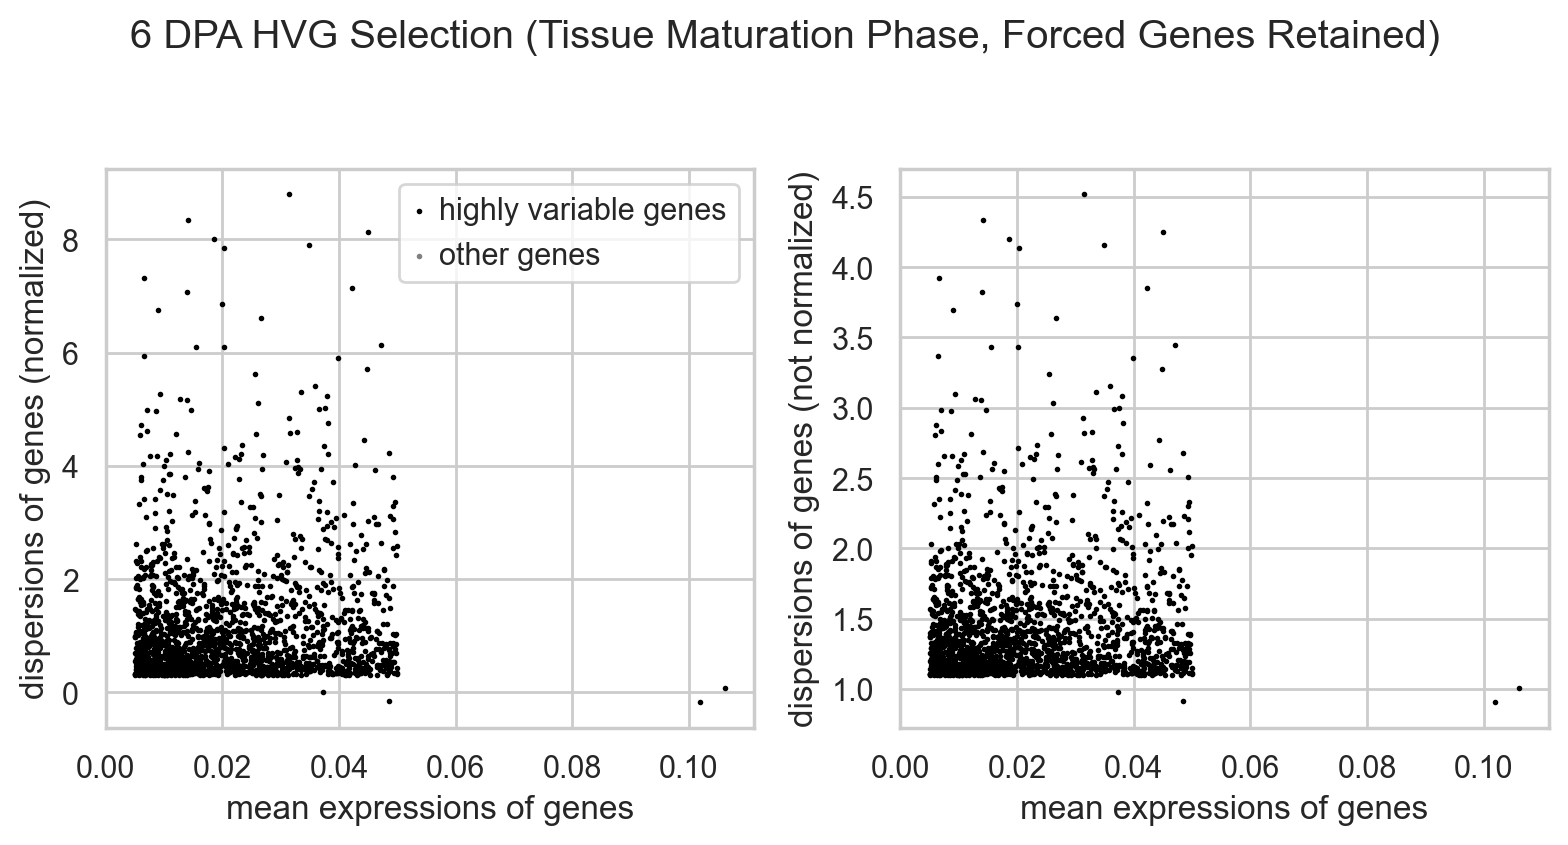

In [6]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

# =============================================
# Data Normalization 
# =============================================
sc.pp.normalize_total(
    adata,
    target_sum=1e4,
    exclude_highly_expressed=False,
    max_fraction=0.15
)
sc.pp.log1p(adata)

# =============================================
# Highly Variable Gene Selection (Homeostasis-Adapted)
# =============================================
mean_threshold = np.percentile(adata.X.data, 99.1) / 100

sc.pp.highly_variable_genes(
    adata,
    min_mean=0.005,
    max_mean=0.05,  # Conservative, focusing on moderately expressed genes
    min_disp=0.3,
    n_top_genes=None,
    batch_key='batch' if 'batch' in adata.obs else None
)

# =============================================
# Force Retain Specific Genes (RNA Pol I-related)
# =============================================
genes_to_keep = ['taf1b', 'rrn3', 'sprtn','polr1d']  # Add more as needed

# Check which genes are present in the dataset
genes_present = [gene for gene in genes_to_keep if gene in adata.var_names]

# Force these genes to be marked as highly variable
adata.var.loc[genes_present, 'highly_variable'] = True

print(f"✅ Selected {sum(adata.var.highly_variable)} highly variable genes")
print(f"🔒 Forced inclusion of genes: {genes_present}")

# =============================================
# Subset to Highly Variable Genes (including forced ones)
# =============================================
adata = adata[:, adata.var.highly_variable]

# =============================================
# Biological Validation Plot
# =============================================
sc.pl.highly_variable_genes(adata, show=False)
plt.suptitle("6 DPA HVG Selection (Tissue Maturation Phase, Forced Genes Retained)", y=1.05)
plt.tight_layout()


C:\Users\uer\anaconda3\envs\scenv\lib\site-packages\scanpy\preprocessing\_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Users\uer\anaconda3\envs\scenv\lib\site-packages\scanpy\preprocessing\_pca\__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(adata, mask_var, use_highly_variable)
C:\Users\uer\AppData\Local\Temp\ipykernel_27336\3964774088.py:17: UserWarning: Ignoring svd_solver='randomized' and using arpack, sklearn.decomposition._pca.PCA (with sparse input) only supports dict_keys(['arpack', 'covariance_eigh']).
  sc.tl.pca(


✅ Scaled data (max_value=10, zero_center=False)


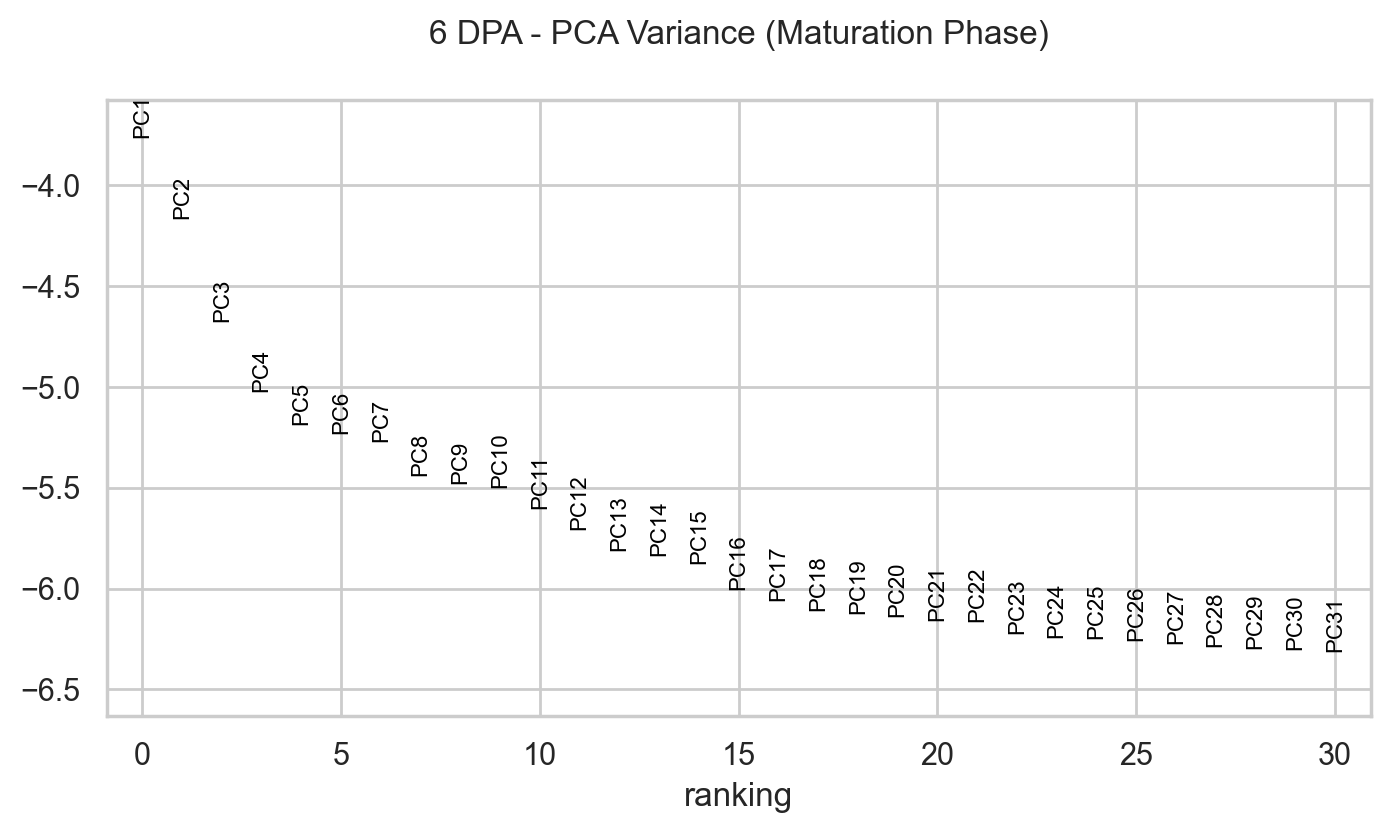

C:\Users\uer\AppData\Local\Temp\ipykernel_27336\3964774088.py:45: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(
saving figure to file figures\umap_6dpa_maturation.png


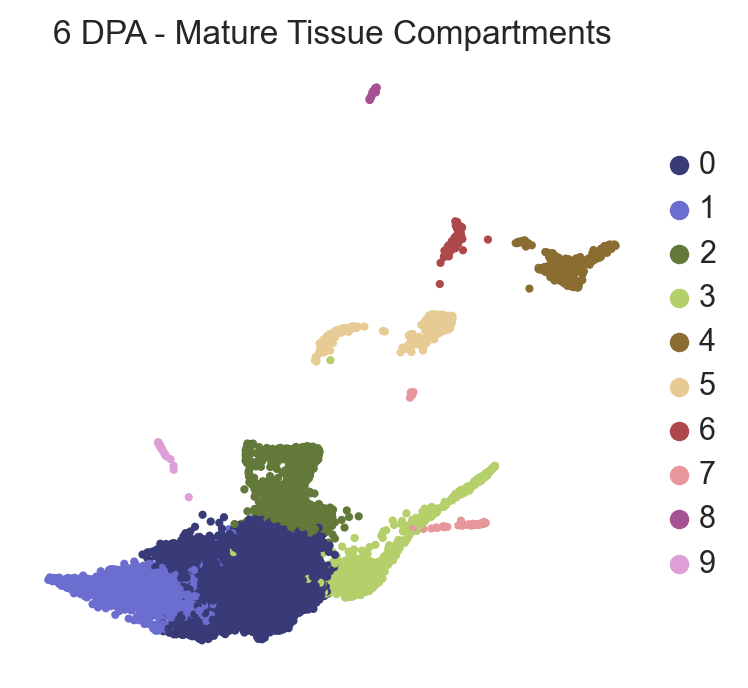

In [7]:
# =============================================
# Feature Scaling (6 DPA Maturation-Optimized)
# =============================================
if 'log1p' in adata.uns_keys():
    sc.pp.scale(
        adata,
        max_value=10,  # More permissive for terminal effector genes
        zero_center=False,  # Avoid negative values for highly expressed structural genes
    )
    print("✅ Scaled data (max_value=10, zero_center=False)")
else:
    print("🟡 Skipping scaling - assumed already normalized")

# =============================================
# Principal Component Analysis (Maturation-Adapted)
# =============================================
sc.tl.pca(
    adata,
    n_comps=40,  # Slightly reduced for cleaner homeostatic patterns
    svd_solver='randomized',  # Faster for stabilized transcriptomes
    use_highly_variable=True,
    random_state=42
)

# Plot variance with maturation markers highlighted
with plt.rc_context({'figure.figsize': (8, 4)}):
    ax = sc.pl.pca_variance_ratio(adata, log=True, show=False)
    plt.title("6 DPA - PCA Variance (Maturation Phase)", pad=20)
    plt.show()

# =============================================
# Nearest-Neighbor Graph (Homeostasis-Optimized)
# =============================================
sc.pp.neighbors(
    adata,
    n_neighbors=20,  # Increased for stable tissue neighborhoods
    n_pcs=25,        # Focus on strongest maintenance signals
    metric='euclidean',  # Better for conserved tissue architecture
    random_state=42
)

# =============================================
# Leiden Clustering (Maturation-Specific)
# =============================================
sc.tl.leiden(
    adata,
    resolution=0.25,  # Higher resolution for mature subtypes
    key_added='leiden_6dpa',  # Timepoint-specific naming
    random_state=42,
    n_iterations=3,   # Fewer iterations for stable tissue organization
    directed=False    # Symmetric relationships in mature tissue
)

# =============================================
# UMAP Visualization (Maturation-Enhanced)
# =============================================
sc.tl.umap(
    adata,
    min_dist=0.4,    # Balanced for tissue maintenance
    spread=1.8,      # Slightly wider for homeostatic spacing
    gamma=0.2,       # Clearer tissue boundaries
    random_state=42,
    init_pos='paga' if 'paga' in adata.uns else 'spectral'  # Leverage prior topology
)

# Plot with maturation context
mature_genes = ['Myl1', 'Krt10', 'Tnni3'] if 'Myl1' in adata.var_names else []
sc.pl.umap(
    adata,
    color=['leiden_6dpa'] + mature_genes,
    palette='tab20b',  # More subtle colors for mature tissues
    frameon=False,
    legend_loc='right margin',  # Detailed legend for mature subtypes
    size=35,           # Medium points for tissue zones
    ncols=2 if mature_genes else 1,
    title='6 DPA - Mature Tissue Compartments',
    save='_6dpa_maturation.png'
)

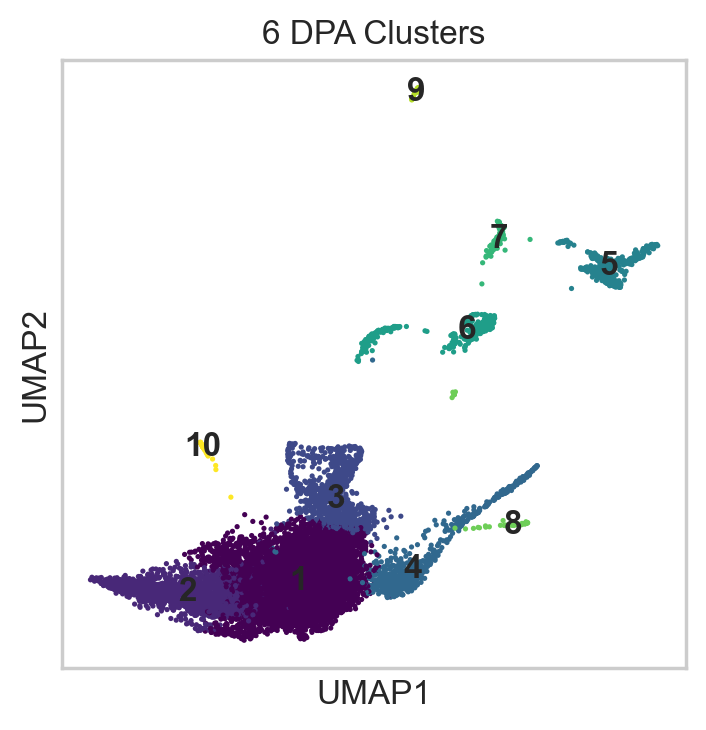

In [8]:
# =============================================
# Cluster Label Formatting
# =============================================
# Convert cluster labels to string type (required for plotting)
adata.obs['leiden_6dpa'] = adata.obs['leiden_6dpa'].astype(int).astype(str)  

# Shift cluster numbering to start at 1 (instead of 0)
adata.obs['leiden_6dpa'] = (adata.obs['leiden_6dpa'].astype(int) + 1).astype(str)

# =============================================
# Visualize Updated Clustering
# =============================================
sc.pl.umap(
    adata, 
    color='leiden_6dpa',          # Color by adjusted cluster labels
    legend_loc='on data',       # Display labels directly on plot
    title='6 DPA Clusters',  # Clear plot title
    palette='viridis'           # Optional: Use colorblind-friendly palette
)

In [9]:
# =============================================
# Basic QC Metrics Summary
# =============================================
print(
    f"\n✅ Baseline QC Summary:\n"
    f"• Cells after filtering: {adata.n_obs:,}\n"
    f"• Median genes per cell: {np.median(adata.obs['n_genes']):.0f}\n"
    f"• Median UMIs per cell: {np.median(adata.obs['n_counts']):,}"
)

# =============================================
# Cluster Composition Analysis
# =============================================
# Count cells per cluster (sorted by cluster number)
print("\n🔬 Cluster Composition (6 DPA):")
print(
    adata.obs['leiden_6dpa']
    .value_counts()
    .sort_index()
    .to_string()  # Cleaner output than default print
)

# =============================================
# Cluster-level QC Metrics
# =============================================
# Calculate median genes and UMIs per cluster
cluster_stats = (
    adata.obs
    .groupby('leiden_6dpa')[['n_genes', 'n_counts']]
    .median()
    .rename(columns={
        'n_genes': 'Median Genes',
        'n_counts': 'Median UMIs'
    })
)

print("\n📊 Cluster Quality Metrics:")
print(cluster_stats.to_markdown(tablefmt="github"))  # GitHub-friendly formatting
# Note: The following code needs 'tabulate' for GitHub-friendly tables.
# If missing, install it via: pip install tabulate


✅ Baseline QC Summary:
• Cells after filtering: 8,519
• Median genes per cell: 1715
• Median UMIs per cell: 4,216.0

🔬 Cluster Composition (6 DPA):
leiden_6dpa
1     4670
2     1458
3      849
4      652
5      363
6      301
7      112
8       53
9       33
10      28

📊 Cluster Quality Metrics:
|   leiden_6dpa |   Median Genes |   Median UMIs |
|---------------|----------------|---------------|
|             1 |         1644   |        3944.5 |
|             2 |         1552.5 |        3968.5 |
|             3 |         2385   |        6233   |
|             4 |         1843.5 |        4528.5 |
|             5 |         2220   |        5241   |
|             6 |         2092   |        4955   |
|             7 |         2300.5 |        5475.5 |
|             8 |         3250   |        9431   |
|             9 |         2509   |        6077   |
|            10 |         2578.5 |        7130.5 |


C:\Users\uer\AppData\Local\Temp\ipykernel_27336\3599341558.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('leiden_6dpa')[['n_genes', 'n_counts']]


In [10]:
# =============================================
# Add Experimental Metadata to AnnData Object
# =============================================
# Time point annotation (crucial for time-series analysis)
adata.obs['time_point'] = '6dpa'  # Options: '0dpa', '1dpa', '2dpa', etc.

In [11]:
# =============================================
# Save Processed 6 DPA Data
# =============================================
adata.write(
    "6_DPA.h5ad",          # Output filename
   # compression="gzip"     # Optional: Reduce file size (~50% smaller)
)

print(f"✅ Successfully saved preprocessed data to '6dpa1.h5ad':")
print(f"   - Cells: {adata.n_obs:,}")
print(f"   - Genes: {adata.n_vars:,}")


✅ Successfully saved preprocessed data to '6dpa1.h5ad':
   - Cells: 8,519
   - Genes: 1,787


In [12]:
# =============================================
# Workflow Summary 
# =============================================

## 0 DPA PROCESSING PIPELINE:
#1. Load Data          : Read 10X Genomics MTX files
#2. Quality Control    : Filter cells (genes >200, UMIs >500, mtDNA <10%)
#3. Normalization      : Total-count (1e4) + log1p
#4. Feature Selection  : HVGs (min_mean=0.0125, max_mean=3)
#5. Dimensionality     : PCA (50 PCs) → Leiden clustering (res=0.05)
#6. Visualization      : UMAP with 1-indexed clusters
#7. Data Export        : Saved as compressed H5AD